In [1]:
devtools::install_github("NPSDC/beaveR", ref = "dev")
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(library(beaveR))
clustFile <- "../brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/terminus/no_threshold_meaninf_0/group_nwk.txt"
quantDir <- file.path("../brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/out_sal") 
samples <- as.vector(outer(c(1:6), c(1,2), function(x,y) paste(x,y,sep='_')))
quantFiles <- file.path(quantDir, samples, 'quant.sf')
coldata <- data.frame(files=quantFiles, names=samples, condition=factor(rep(1:2, each=6)))
# tse <- buildTSE(treeTermFile = clustFile, coldata = coldata)

Skipping install of 'beaveR' from a github remote, the SHA1 (55f74bc0) has not changed since last install.
  Use `force = TRUE` to force installation



In [35]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
saveDir <- "environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees/DE"
# save(tse, file=file.path(saveDir, "tseMean.RData"))
load(file.path(saveDir, "tseMean.RData"))

In [36]:
temp <- tse
tree <- rowTree(tse)
l <- length(tree$tip)

In [61]:
load("environment/brain_sim_nodtu/mode=gc_bias/simulate.rda")
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(ape))
tree <- rowTree(tse)
l <- length(tree$tip)
missingTxps <- setdiff(rownames(tse)[1:l], rownames(sim.counts.mat))
dts <- Reduce(union, c(names(iso.dge)[iso.dge], names(iso.dte)[iso.dte], names(iso.dte.only)[iso.dte.only], 
                       names(iso.dtu)[iso.dtu]))
dts <- intersect(dts, rownames(sim.counts.mat))
sim.counts.mat <- rbind(sim.counts.mat, matrix(0, nrow = length(missingTxps), ncol = ncol(sim.counts.mat),
                                               dimnames = list(missingTxps, colnames(sim.counts.mat))))
sim.counts.mat <- sim.counts.mat[rownames(tse)[1:l],]
dts <- intersect(dts, rownames(sim.counts.mat))

innNodes <- l+1:tree$Nnode
aggCountsNodes <- computeAggNodesU(tree, c(1:length(tree$tip),innNodes), sim.counts.mat)
logFCNodes <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))
names(logFCNodes)[(l+1):length(logFCNodes)] <- paste("Node", names(logFCNodes)[(l+1):length(logFCNodes)], sep="")
rootFC <- abs(logFCNodes[l+1])


In [14]:
length(dts)
summary(abs(logFCNodes[dts]))
print(mean(abs(logFCNodes[dts]) >= rootFC))
rootFC
mcols(tse)[["meanInfRV"]][l+1]

[1] 8799

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8858  1.5380  1.9329  1.8816  2.2746  2.5824 

[1] 1


Node138760 
0.03264375

Node138760 
      0.01

In [10]:
metadata(tse)[["sf"]]

NULL

#### Run Swish

In [94]:
set.seed(1)
y <- fishpond::scaleInfReps(temp[1:l,])
y <- labelKeep(y)
y <- swish(y, x="condition")

In [95]:
detNodes <- list()
detNodes[["Swish"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(y)[,"qvalue"] <= x ))

negNodes <- list()
negNodes[["Swish"]] <- lapply(detNodes[["Swish"]], function(nodes) setdiff(seq(l), 
                                                          unlist(Descendants(tree, nodes))))

#### Min meanInfRV and Height

In [27]:
lambda <- c(0.05, 0.1, 1, 5, 10)
cuts <- list()

In [38]:
tree
treeMean


Phylogenetic tree with 138759 tips and 119966 internal nodes.

Tip labels:
  ENST00000419160.3, ENST00000416931.1, ENST00000457540.1, ENST00000414273.1, ENST00000514057.1, ENST00000412115.1, ...
Node labels:
  Node138760, Node138761, Node138762, Node138763, Node138764, Node138765, ...

Unrooted; no branch lengths.


Phylogenetic tree with 135143 tips and 119966 internal nodes.

Tip labels:
  ENST00000621901.1, ENST00000453593.5, ENST00000265723.8, ENST00000358400.7, ENST00000359206.7, ENST00000184183.8, ...
Node labels:
  Node135144, Node135145, Node135146, Node135147, Node135148, Node135149, ...

Unrooted; no branch lengths.

In [28]:
for(i in lambda) {
    descSize <- sapply(Descendants(tree, seq(nrow(tse))), length)
    metric <- (mcols(tse)[['meanInfRV']] + node.depth(tree, 2)*i) *descSize
    objS <- solveForOptimalCut(tse, metVec = metric, type = 'min')
    gammaN <- paste("gamma",i,sep="=")
    cuts[[gammaN]] <- objS[["cut"]]
}
names(cuts) <- paste("irv", "height", lambda, sep = "_") 
sapply(cuts,length)

irv_height_0.05  irv_height_0.1    irv_height_1    irv_height_5   irv_height_10 
          74891           85817          116909          130374          133130

In [29]:
for(i in seq_along(lambda)) {
     ihname <- paste("irv", "height", lambda[i], sep = "_") 
     y <- temp[sort(cuts[[ihname]]),]
     y <- fishpond::scaleInfReps(y)
     y <- labelKeep(y)
     set.seed(1)
     y <- swish(y, x="condition")
#      dim(y)
     detNodes[[ihname]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(y)[which(mcols(y)[,"qvalue"] <= x)]
#         txps <- match(nodes[grep("ENST", nodes)], rownames(tse))
#         iNodes <- match(nodes[grep("Node", nodes)], rownames(tse))
         match(nodes, names(logFCNodes))
        
#         c(txps,iNodes)
    })
    negNodes[[ihname]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(y)[setdiff(seq(nrow(y)), which(mcols(y)[,"qvalue"] <= x))]
        match(nodes, names(logFCNodes))
    })
}

ERROR: Error in eval(expr, envir, enclos): object 'temp' not found


#### Max Weighted Log Fold Change

In [ ]:
getLog2FC <- function(tse, condition, pc=5, array=FALSE) {
  infRepIdx <- grep("infRep", assayNames(tse))
  infReps <- assays(tse)[infRepIdx]
  infRepsArray <- abind::abind(as.list(infReps), along=3)
  dims <- dim(infRepsArray)
    
  cond1 <- condition == levels(condition)[1]
  cond2 <- condition == levels(condition)[2]

  diffs <- matrix(nrow=dims[1],ncol=dims[3])
  for (k in seq_len(dims[3])) {
    diffs[,k] <- log2(rowMeans(infRepsArray[,cond2,k]) + pc) -
                 log2(rowMeans(infRepsArray[,cond1,k]) + pc)
  }
  if (array) {
    return(diffs)
  }
  # median over inferential replicates
  rowMedians(diffs)
}

In [ ]:
tse <- computeSizeFactors(tse, type="txp")
tse <- scaleInfReps(tse)
lfc <- getLog2FC(tse, colData(tse)[["condition"]])
descSize <- sapply(phangorn::Descendants(tree, seq(nrow(tse))), length)
metric <- abs(lfc)/mcols(tse)[['meanInfRV']]
objS <- solveForOptimalCut(tse, metVec = metric, type = 'max')
cuts[["LFC"]] <- objS[["cut"]]

In [ ]:
y <- temp[sort(cuts[["LFC"]]),]
y <- fishpond::scaleInfReps(y)
y <- labelKeep(y)
set.seed(1)
y <- swish(y, x="condition")

detNodes[["LFC"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
    nodes <- rownames(y)[which(mcols(y)[,"qvalue"] <= x)]
    match(nodes, names(logFCNodes))
})
negNodes[["LFC"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(y)[setdiff(seq(nrow(y)), which(mcols(y)[,"qvalue"] <= x))]
        match(nodes, names(logFCNodes))
})

#### TPM LFC Desc

In [ ]:
# lfcTPM <- getScaledLFC(temp, "condition")
# metric <- abs(lfcTPM)/mcols(tse)[['meanInfRV']]*descSize
# objS <- solveForOptimalCut(tse, metVec = metric, type = 'max')
# cuts[["lfcTPMDesc"]] <- objS[["cut"]]
y <- temp[sort(cuts[["lfcTPMDesc"]]),]
y <- fishpond::scaleInfReps(y)
y <- labelKeep(y)
set.seed(1)
y <- swish(y, x="condition")

detNodes[["lfcTPMDesc"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
    nodes <- rownames(y)[which(mcols(y)[,"qvalue"] <= x)]
    match(nodes, names(logFCNodes))
})
negNodes[["lfcTPMDesc"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(y)[setdiff(seq(nrow(y)), which(mcols(y)[,"qvalue"] <= x))]
        match(nodes, names(logFCNodes))
    })

#### TPM LFC

In [ ]:
# lfcTPM <- getScaledLFC(temp, "condition")
# metric <- abs(lfcTPM)/mcols(tse)[['meanInfRV']]
# objS <- solveForOptimalCut(tse, metVec = metric, type = 'max')
# cuts[["lfcTPM"]] <- objS[["cut"]]
y <- temp[sort(cuts[["lfcTPM"]]),]
y <- fishpond::scaleInfReps(y)
y <- labelKeep(y)
set.seed(1)
y <- swish(y, x="condition")

detNodes[["lfcTPM"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
    nodes <- rownames(y)[which(mcols(y)[,"qvalue"] <= x)]
    match(nodes, names(logFCNodes))
})
negNodes[["lfcTPM"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(y)[setdiff(seq(nrow(y)), which(mcols(y)[,"qvalue"] <= x))]
        match(nodes, names(logFCNodes))
    })

In [59]:
# suppressPackageStartupMessages(source("old_terminus_helper.R"))
# dir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/terminus/"
# seBrainSim <- tximeta(coldata)
# seBrainSim <- labelKeep(seBrainSim)
# treeMean <- read.tree("../brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/terminus/no_threshold_meaninf_0/group_nwk.txt")
# groupsClust <- parseClustFile(file.path(dir, "old", "1_1", "clusters.txt"), seBrainSim)
# txpsTree <- unlist(lapply(treeMean, function(tree) as.numeric(tree$tip.label)+1))
# setdiff(unlist(groupsClust),txpsTree)
# txpsFinal <- rownames(seBrainSim)[Reduce(union, list(unlist(groupsClust), txpsTree, which(mcols(seBrainSim)[["keep"]])))]
# tse <- buildTSE(treeTermFile = clustFile, coldata = coldata, txps = txpsFinal)
l <- length(rowTree(tse)$tip)
yTermThrNS <- seBrainSim[rownames(tse)[1:l],]
groupsClust <- parseClustFile(file.path(dir, "old", "1_1", "clusters.txt"), yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepOSwish(yTermThrNS, mInds, groupsClust)

rownames(yAggTermThrNS)[l+1:length(groupsClust)] <- paste("Node", as.character(l+1:length(groupsClust)),sep="")
metadata(yAggTermThrNS)[["txpsAnn"]] <- rowData(yTermThrNS)
yAggTermThrNS <- yAggTermThrNS[-unlist(groupsClust),]
dim(yAggTermThrNS)

[1] 130552     12

In [54]:
txpsFinal <- rownames(seBrainSim)[Reduce(union, list(unlist(groupsClust), txpsTree, which(mcols(seBrainSim)[["keep"]])))]
length(txpsTree)
length(txpsFinal)
length(tree$tip)

[1] 135138

[1] 138764

[1] 138759

In [62]:
aggCountsNodes <- computeOAggNodesU(groupsClust, mInds, sim.counts.mat)
logFCNodesTerm <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))
names(logFCNodesTerm)[(l+1):length(logFCNodesTerm)] <- paste("Node", names(logFCNodesTerm)[(l+1):length(logFCNodesTerm)], sep="")

yAggTermThrNS <- fishpond::scaleInfReps(yAggTermThrNS)
yAggTermThrNS <- labelKeep(yAggTermThrNS)
set.seed(1)
yAggTermThrNS <- swish(yAggTermThrNS, x="condition")

In [63]:
detNodes <- list()
negNodes <- list()
detNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yAggTermThrNS)[which(mcols(yAggTermThrNS)[,"qvalue"] <= x)]
        match(nodes, names(logFCNodesTerm))
    })
negNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yAggTermThrNS)[setdiff(seq(nrow(yAggTermThrNS)),
                                                 which(mcols(yAggTermThrNS)[,"qvalue"] <= x))]
        match(nodes, names(logFCNodesTerm))
    })
stats <-  sapply(seq_along(detNodes[["term"]]), function(i) computeMetOut(detNodes[["term"]][[i]], 
                                                                          logFCNodesTerm, tree = NULL, 
                                                                          negNodes = negNodes[["term"]][[i]],
                                                                          lfcThresh = rootFC))
colnames(stats) <- colnames(df)[c(3:5)]
stats <- cbind(Method=rep("term",2), Metric = c("FDR", "TPR"), stats)
print(stats)

[1] "tp 0.99075595727198"
[1] "tp 0.962414768002661"
[1] "tp 0.924082602882187"
    Method Metric                                 
fdr "term" "FDR"  0.009244043 0.03758523 0.0759174
tpr "term" "TPR"  0.5936      0.7122462  0.7655385


In [102]:
df <- data.frame(Method=character(), Metric=character(), FDR_0.01 = numeric(), FDR_0.05 = numeric(), FDR_0.10 = numeric())
for(n in names(detNodes))
{
    print(n)
    stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], logFCNodes, tree = tree, negNodes = negNodes[[n]][[i]], lfcThresh = rootFC))
    colnames(stats) <- colnames(df)[c(3:5)]
    stats <- cbind(Method=rep(n,2), Metric = c("FDR", "TPR"), stats)
    df <- rbind(df, stats)
}
print(df)

[1] "Swish"
[1] "tp 0.990465071025491"
[1] "tp 0.962445003142678"
[1] "tp 0.926497404965633"
[1] "irv_height_0.05"
[1] "tp 0.990189873417721"
[1] "tp 0.962002096436059"
[1] "tp 0.924371740161214"
[1] "irv_height_0.1"
[1] "tp 0.988809182209469"
[1] "tp 0.959091983920549"
[1] "tp 0.92020592020592"
[1] "irv_height_1"
[1] "tp 0.998265093684941"
[1] "tp 0.965827668565129"
[1] "tp 0.926988265971317"
[1] "irv_height_5"
[1] "tp 0.990663488279698"
[1] "tp 0.957460418998881"
[1] "tp 0.922096520120292"
[1] "irv_height_10"
[1] "tp 0.990274265707061"
[1] "tp 0.955559020739124"
[1] "tp 0.919341334077589"
[1] "LFC"
[1] "tp 0.988722950320024"
[1] "tp 0.959214501510574"
[1] "tp 0.914936823104693"
[1] "lfcTPMDesc"
[1] "tp 0.990125332320547"
[1] "tp 0.962094442659814"
[1] "tp 0.923234092235844"
[1] "lfcTPM"
[1] "tp 0.988598859885989"
[1] "tp 0.961711711711712"
[1] "tp 0.919837874352623"
              Method Metric    FDR_0.01   FDR_0.05   FDR_0.10
fdr            Swish    FDR 0.009534929   0.037555  0.073

In [101]:
# saveDir <- "environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees/DE"
# save(cuts, file=file.path(saveDir, "cutsMean.RData"))
# save(df, file=file.path(saveDir, "dfMean.RData"))
save(detNodes, file=file.path(saveDir, "detNodesMean.RData"))
save(negNodes, file=file.path(saveDir, "negNodesMean.RData"))

In [8]:
suppressPackageStartupMessages(library(ggplot2))

In [35]:
load(file=file.path(saveDir, "dfMean.RData"))
# head(df)
# df <- fixDf(df)
# df$level <- rep(c(0.01,0.05,0.1), length(unique(df$Method)))
# df$meetCriteria <- rep(FALSE, nrow(df))
# for(i in seq(3)) {
#     df$meetCriteria[seq(i,27,3)] <- df$FDR[seq(1,nrow(df),3)] < c(0.01,0.05,0.1)[i]
# }


In [82]:
dfB <- cbind(gather(df[seq(1, nrow(df), 2),], key = "NFDR", value = "FDR", 3:5),
gather(df[seq(2, nrow(df), 2),], key = "NFDR", value = "TPR", 3:5))
dfB <- dfB[, c(1,3,4,8)]
dfB[["meetCriteria"]] <- rep(FALSE, nrow(dfB))
for(i in seq(3)) {
    start <- (i-1)*9+1
    end <- start+8
    dfB$meetCriteria[start:end] <- dfB$FDR[start:end] <= c(0.01,0.05,0.1)[i]
}

dfB

Method,NFDR,FDR,TPR,meetCriteria
<list>,<chr>,<list>,<list>,<lgl>
Swish,FDR_0.01,0.009534929,0.5784748,TRUE
irv_height_0.05,FDR_0.01,0.009810127,0.6166732,TRUE
irv_height_0.1,FDR_0.01,0.01119082,0.6228086,FALSE
irv_height_1,FDR_0.01,0.001734906,0.3911093,TRUE
irv_height_5,FDR_0.01,0.009336512,0.5950364,TRUE
irv_height_10,FDR_0.01,0.009725734,0.5914953,TRUE
LFC,FDR_0.01,0.01127705,0.6273448,FALSE
lfcTPMDesc,FDR_0.01,0.009874668,0.6440217,TRUE
lfcTPM,FDR_0.01,0.01140114,0.6349971,FALSE


In [83]:
dfB <- data.frame(do.call(cbind, lapply(dfB, unlist)))
dfB[,c(3)] <- as.numeric(dfB[,c(3)])
dfB[,c(4)] <- as.numeric(dfB[,c(4)])

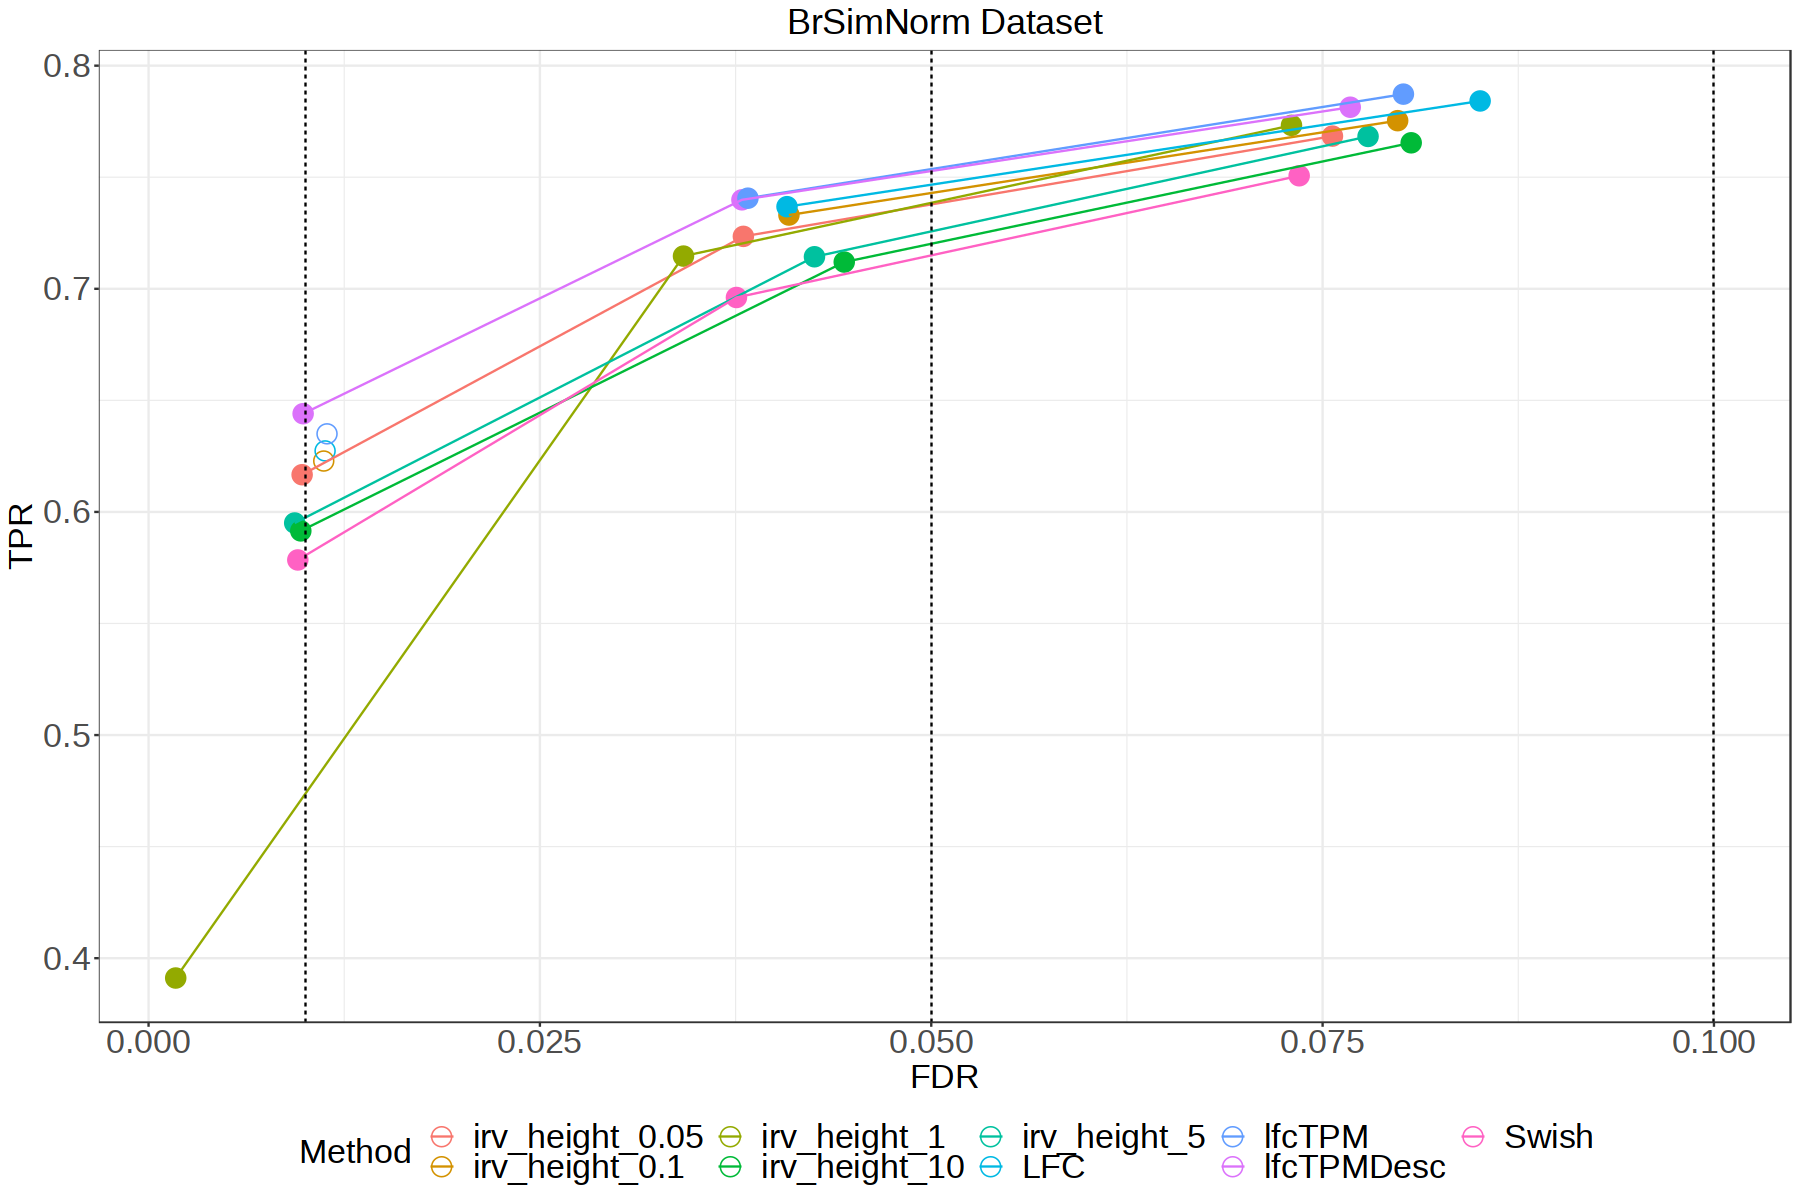

In [84]:
options(repr.plot.width=15, repr.plot.height=10)
size <- 20
pMean <- ggplot(dfB, aes(x = FDR, y = TPR, 
                             color = Method,
                             fill = ifelse(meetCriteria, Method, NA))) + 
                geom_point(size=5,shape=21) + 
                scale_fill_discrete(na.value = "transparent") +
                geom_line() +
                theme_bw() +
                geom_vline(xintercept = c(0.01, 0.05, 0.1), linetype = "dashed") +
                ggtitle("BrSimNorm Dataset") +
                theme(axis.title = element_text(size = size),
                plot.title = element_text(size = size + 1, hjust=0.5),
                axis.text = element_text(size = size),
                legend.text = element_text(size = size),
                legend.title = element_text(size = size),
                legend.position = "bottom") +
                guides(fill = "none")
pMean

In [64]:
negNodesDesc <- list()
# for(n in names(negNodes)) {
#     if(n == "Swish")
#         negNodesDesc[[n]] <- negNodes[[n]]
#     if(n != "term")
#         negNodesDesc[[n]] <- lapply(negNodes[[n]], function(x) unlist(Descendants(tree, x)))
# }
n <- "term"
negNodesDesc[["term"]] <- lapply(negNodes[["term"]], function(x) {
    dd <- x[x>l]
    r <- setdiff(x, dd)
    dd <- dd - l
    c(unlist(groupsClust[dd]), r) 
})
stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], 
                                                                             logFCNodesTerm, tree = tree, 
                                                                             negNodes = negNodesDesc[[n]][[i]], 
                                                                             lfcThresh = rootFC))
        colnames(stats) <- colnames(df)[c(3:5)]
        stats <- cbind(Method=rep(n,2), Metric = c("FDR", "TPR"), stats)
print(stats)

[1] "tp 0.99075595727198"
[1] "tp 0.962414768002661"
[1] "tp 0.924082602882187"
    Method Metric                                 
fdr "term" "FDR"  0.009244043 0.03758523 0.0759174
tpr "term" "TPR"  0.5904027   0.7100613  0.7637525


In [24]:
sapply(negNodes[["lfcTPM"]],length)
sapply(negNodesDesc[["lfcTPM"]],length)


[1] 83442 82779 82334

[1] 125497 123646 122411

In [104]:
dfO <- data.frame(Method=character(), Metric=character(), FDR_0.01 = numeric(), FDR_0.05 = numeric(), FDR_0.10 = numeric())
for(n in names(detNodes))
{
    print(n)
    if(n != "term") {
        stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], 
                                                                             logFCNodes, tree = tree, 
                                                                             negNodes = negNodesDesc[[n]][[i]], 
                                                                             lfcThresh = rootFC))
        colnames(stats) <- colnames(df)[c(3:5)]
        stats <- cbind(Method=rep(n,2), Metric = c("FDR", "TPR"), stats)
        dfO <- rbind(dfO, stats)
    }
    
}
print(dfO)

[1] "Swish"
[1] "tp 0.990465071025491"
[1] "tp 0.962445003142678"
[1] "tp 0.926497404965633"
[1] "irv_height_0.05"
[1] "tp 0.990189873417721"
[1] "tp 0.962002096436059"
[1] "tp 0.924371740161214"
[1] "irv_height_0.1"
[1] "tp 0.988809182209469"
[1] "tp 0.959091983920549"
[1] "tp 0.92020592020592"
[1] "irv_height_1"
[1] "tp 0.998265093684941"
[1] "tp 0.965827668565129"
[1] "tp 0.926988265971317"
[1] "irv_height_5"
[1] "tp 0.990663488279698"
[1] "tp 0.957460418998881"
[1] "tp 0.922096520120292"
[1] "irv_height_10"
[1] "tp 0.990274265707061"
[1] "tp 0.955559020739124"
[1] "tp 0.919341334077589"
[1] "LFC"
[1] "tp 0.988722950320024"
[1] "tp 0.959214501510574"
[1] "tp 0.914936823104693"
[1] "lfcTPMDesc"
[1] "tp 0.990125332320547"
[1] "tp 0.962094442659814"
[1] "tp 0.923234092235844"
[1] "lfcTPM"
[1] "tp 0.988598859885989"
[1] "tp 0.961711711711712"
[1] "tp 0.919837874352623"
              Method Metric    FDR_0.01   FDR_0.05   FDR_0.10
fdr            Swish    FDR 0.009534929   0.037555  0.073

In [38]:
save(dfO, file=file.path(saveDir, "dfMeanO.RData"))

In [86]:
load(file.path(saveDir, "dfMeanO.RData"))
dfB <- cbind(gather(dfO[seq(1, nrow(dfO), 2),], key = "NFDR", value = "FDR", 3:5),
gather(dfO[seq(2, nrow(dfO), 2),], key = "NFDR", value = "TPR", 3:5))
dfB <- dfB[, c(1,3,4,8)]
dfB[["meetCriteria"]] <- rep(FALSE, nrow(dfB))
for(i in seq(3)) {
    start <- (i-1)*9+1
    end <- start+8
    dfB$meetCriteria[start:end] <- dfB$FDR[start:end] <= c(0.01,0.05,0.1)[i]
}

dfB

Method,NFDR,FDR,TPR,meetCriteria
<list>,<chr>,<list>,<list>,<lgl>
Swish,FDR_0.01,0.009534929,0.5784748,TRUE
irv_height_0.05,FDR_0.01,0.009810127,0.5721338,TRUE
irv_height_0.1,FDR_0.01,0.01119082,0.5893621,FALSE
irv_height_1,FDR_0.01,0.001734906,0.3799023,TRUE
irv_height_5,FDR_0.01,0.009336512,0.5927731,TRUE
irv_height_10,FDR_0.01,0.009725734,0.5906718,TRUE
LFC,FDR_0.01,0.01127705,0.5966526,FALSE
lfcTPMDesc,FDR_0.01,0.009874668,0.572967,TRUE
lfcTPM,FDR_0.01,0.01140114,0.6062557,FALSE


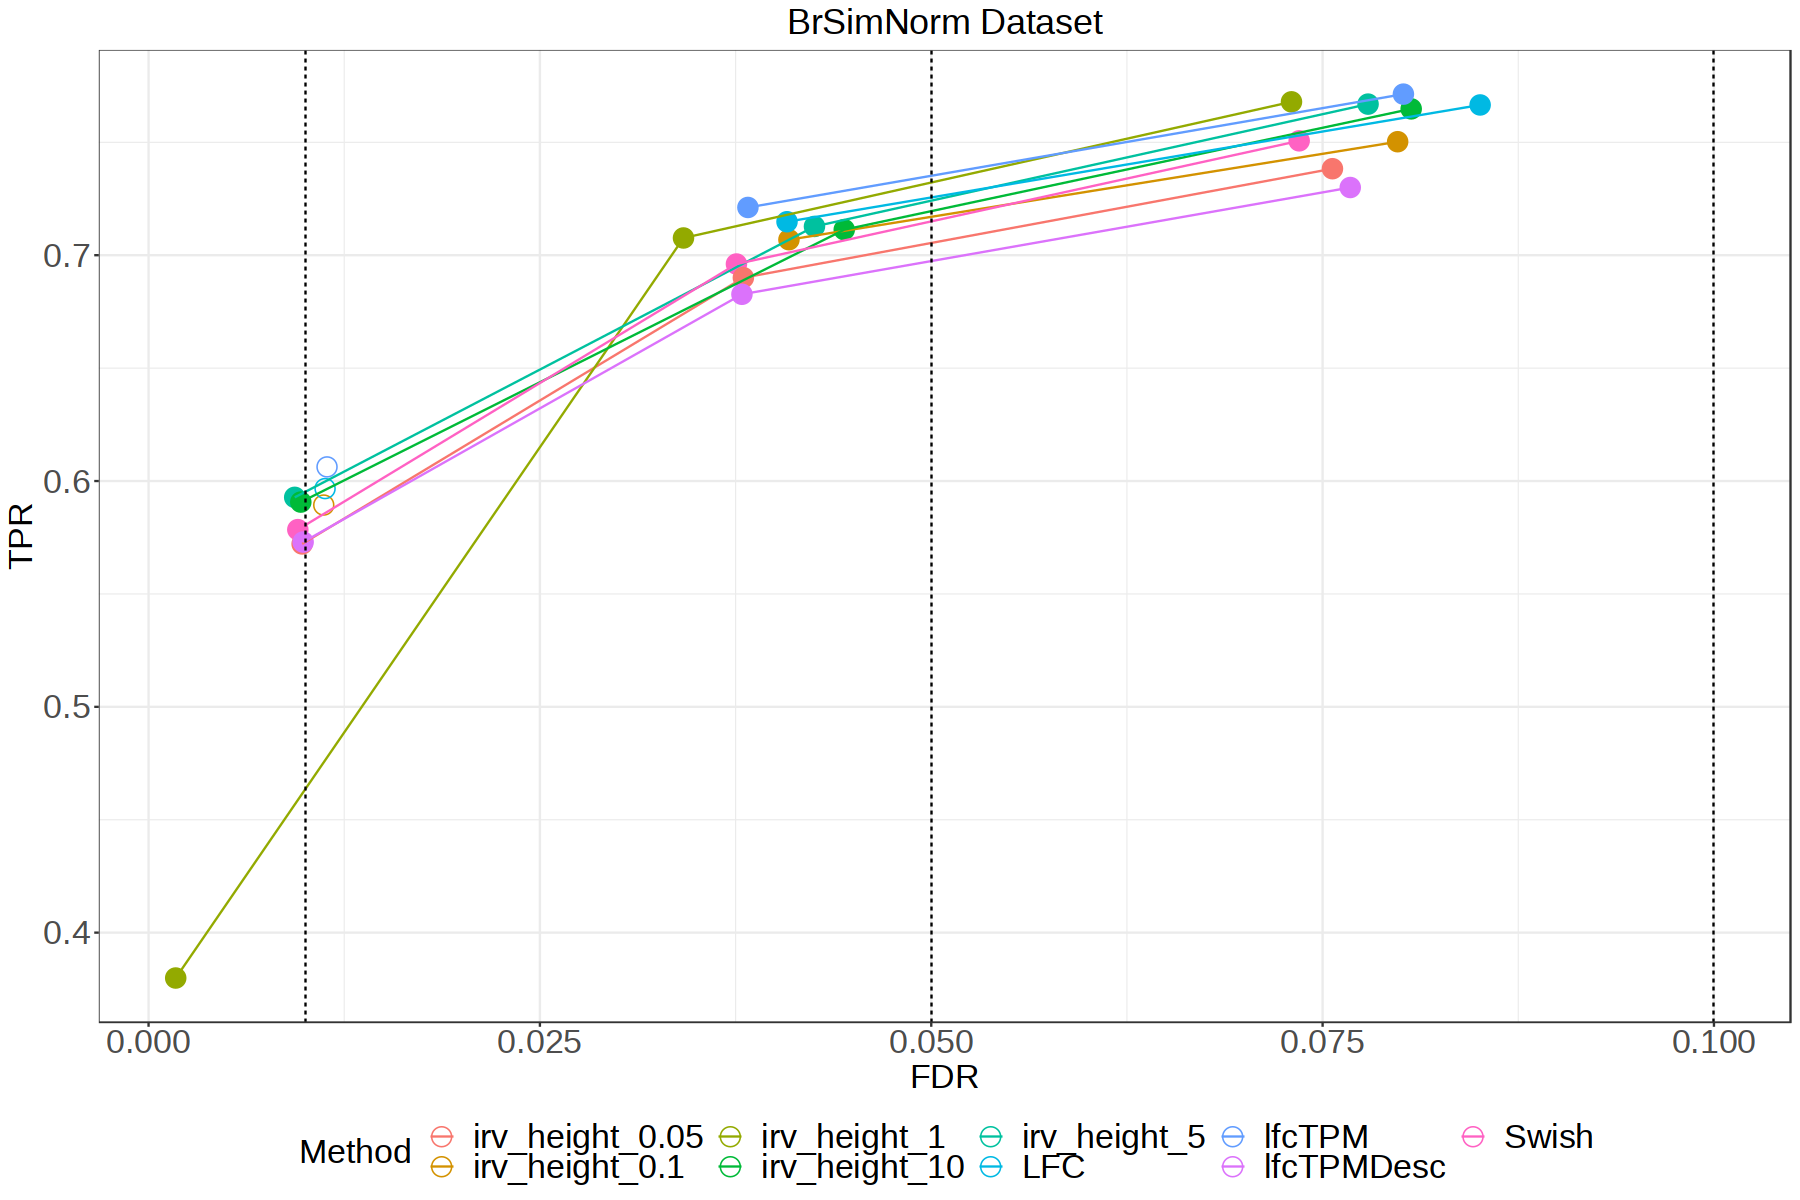

In [89]:
dfB <- data.frame(do.call(cbind, lapply(dfB, unlist)))
dfB[,c(3)] <- as.numeric(dfB[,c(3)])
dfB[,c(4)] <- as.numeric(dfB[,c(4)])
options(repr.plot.width=15, repr.plot.height=10)
size <- 20
pMeanDesc <- ggplot(dfB, aes(x = FDR, y = TPR, 
                             color = Method,
                             fill = ifelse(meetCriteria, Method, NA))) + 
                geom_point(size=5,shape=21) + 
                scale_fill_discrete(na.value = "transparent") +
                geom_line() +
                theme_bw() +
                geom_vline(xintercept = c(0.01, 0.05, 0.1), linetype = "dashed") +
                ggtitle("BrSimNorm Dataset") +
                theme(axis.title = element_text(size = size),
                plot.title = element_text(size = size + 1, hjust=0.5),
                axis.text = element_text(size = size),
                legend.text = element_text(size = size),
                legend.title = element_text(size = size),
                legend.position = "bottom") +
                guides(fill = "none")
pMeanDesc

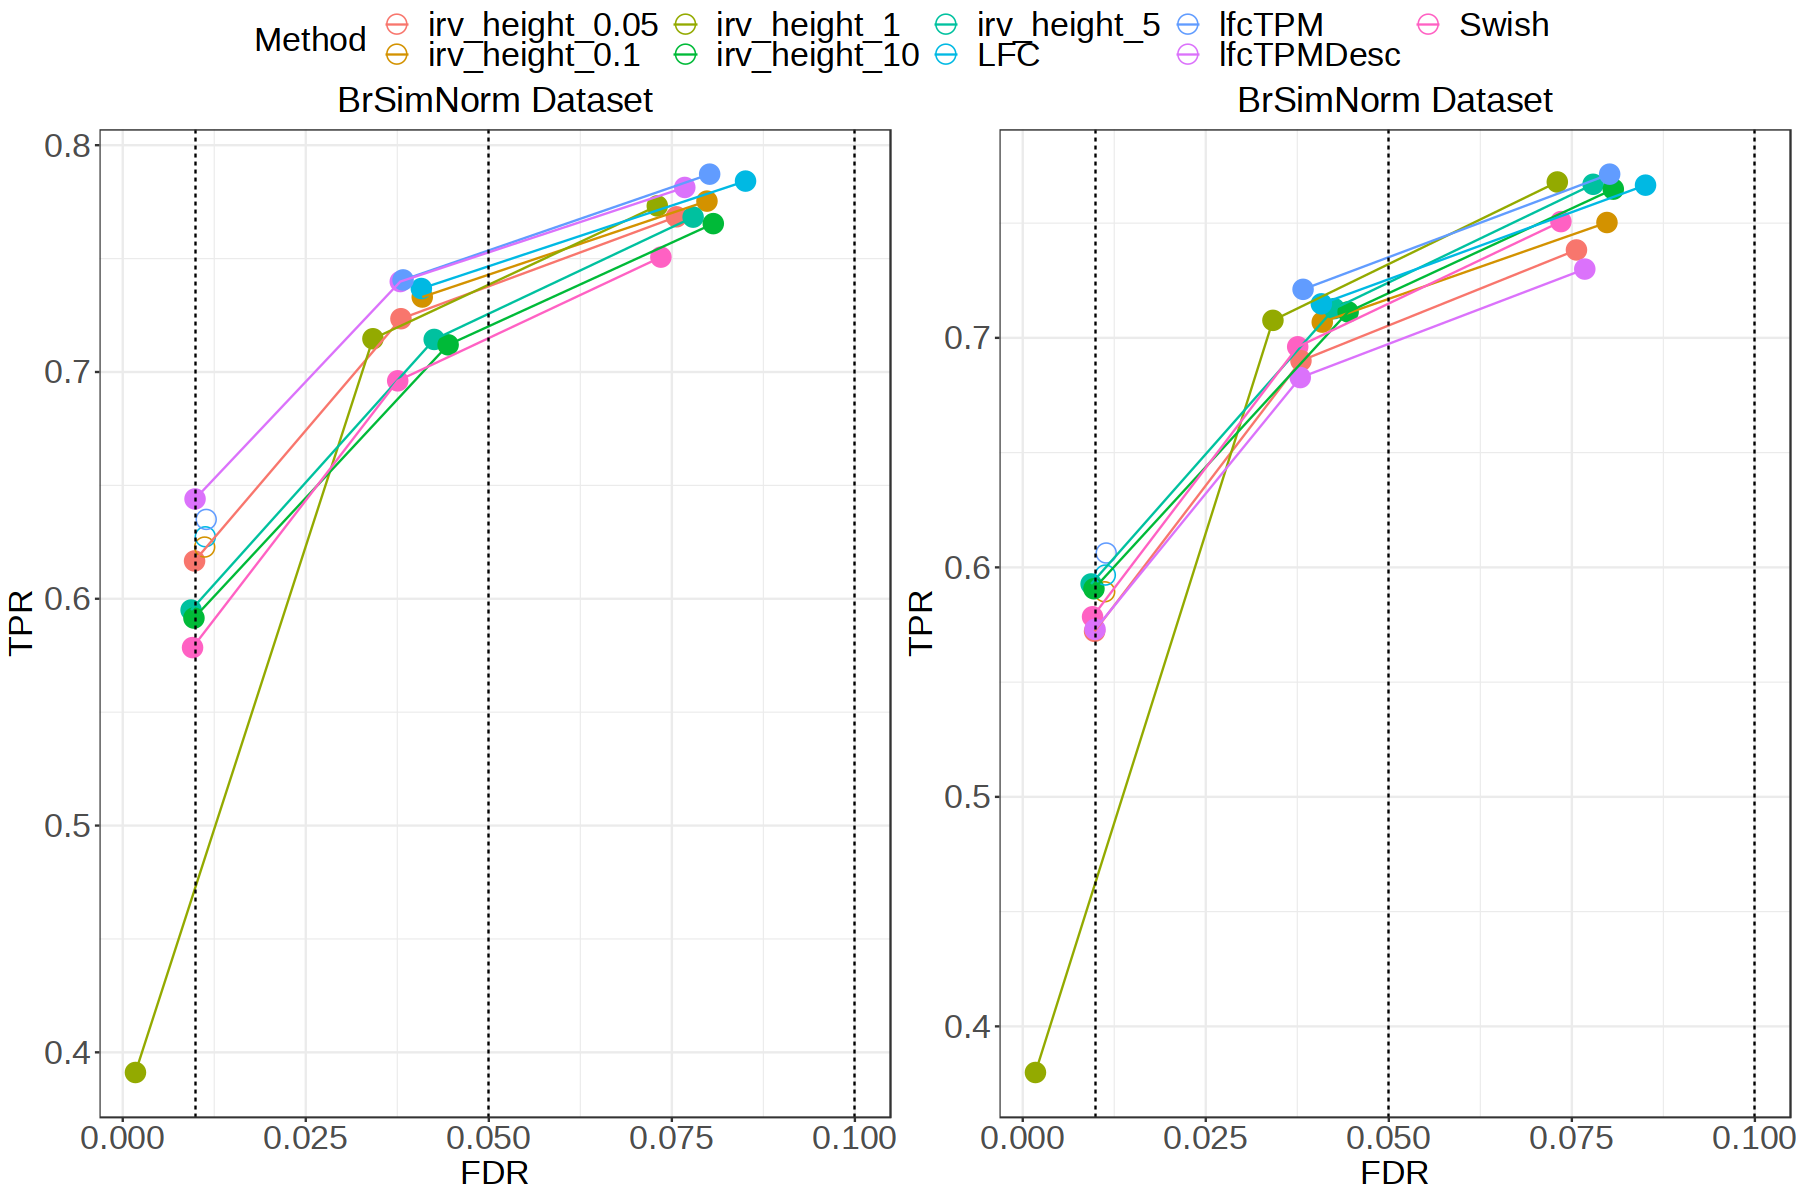

In [90]:
library(ggpubr)
ggarrange(pMean, pMeanDesc, common.legend = T)

In [80]:
df

,Method,Metric,FDR_0.01,FDR_0.05,FDR_0.10
,<named list>,<named list>,<named list>,<named list>,<named list>
fdr,Swish,FDR,0.009534929,0.037555,0.0735026
tpr,Swish,TPR,0.5784748,0.6961018,0.7506535
fdr1,irv_height_0.05,FDR,0.009810127,0.0379979,0.07562826
tpr1,irv_height_0.05,TPR,0.6166732,0.7234923,0.7684273
fdr2,irv_height_0.1,FDR,0.01119082,0.04090802,0.07979408
tpr2,irv_height_0.1,TPR,0.6228086,0.7330562,0.7753479
fdr3,irv_height_1,FDR,0.001734906,0.03417233,0.07301173
tpr3,irv_height_1,TPR,0.3911093,0.7146547,0.7732463
fdr4,irv_height_5,FDR,0.009336512,0.04253958,0.07790348


In [81]:
dfO

,Method,Metric,FDR_0.01,FDR_0.05,FDR_0.10
,<named list>,<named list>,<named list>,<named list>,<named list>
fdr,Swish,FDR,0.009534929,0.037555,0.0735026
tpr,Swish,TPR,0.5784748,0.6961018,0.7506535
fdr1,irv_height_0.05,FDR,0.009810127,0.0379979,0.07562826
tpr1,irv_height_0.05,TPR,0.5721338,0.6900376,0.7383071
fdr2,irv_height_0.1,FDR,0.01119082,0.04090802,0.07979408
tpr2,irv_height_0.1,TPR,0.5893621,0.7068665,0.7502623
fdr3,irv_height_1,FDR,0.001734906,0.03417233,0.07301173
tpr3,irv_height_1,TPR,0.3799023,0.7076323,0.7679222
fdr4,irv_height_5,FDR,0.009336512,0.04253958,0.07790348
